# Импорты

In [22]:
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from src.data.dataset import TableDataset
from src.util.util import enumerateWithEstimate

# Примеры изображений в наборе данных

Text(0.5, 1.0, 'Чистый стол')

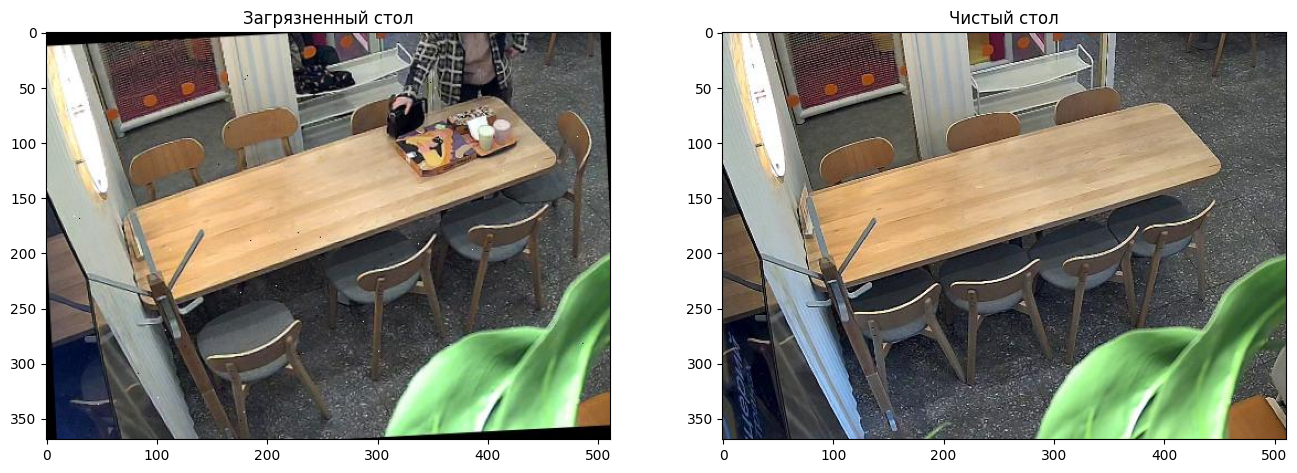

In [4]:
# Чтение изображения с загрязненным столом
img_dirty = cv2.imread('dataset/dirty/table1_frame_00087_jpg.rf.6e664c1a0a9479d0b45402c78c4d94c5.jpg')
img_dirty = cv2.cvtColor(img_dirty, cv2.COLOR_BGR2RGB)

# Чтение изображения с загрязненным столом
img_clean = cv2.imread('dataset/clean/table1_frame_00006_jpg.rf.344179ffb6fd3f8de99c1cfbe957642f.jpg')
img_clean = cv2.cvtColor(img_clean, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(img_dirty)
plt.title('Загрязненный стол')

plt.subplot(1, 2, 2)
plt.imshow(img_clean)
plt.title('Чистый стол')


# Пример работы с классом TableDataset

## Создание тренировочного набора данных

In [5]:
# Создание тренировочного набора данных с шагом 10 для валидации
data = TableDataset(val_stride=10, isValSet_bool=False)

print(f"Размер тренировочного набора данных: {len(data)}")

Размер тренировочного набора данных: 2907


Размер изображения: torch.Size([3, 512, 475])
Метка класса: tensor([1, 0])


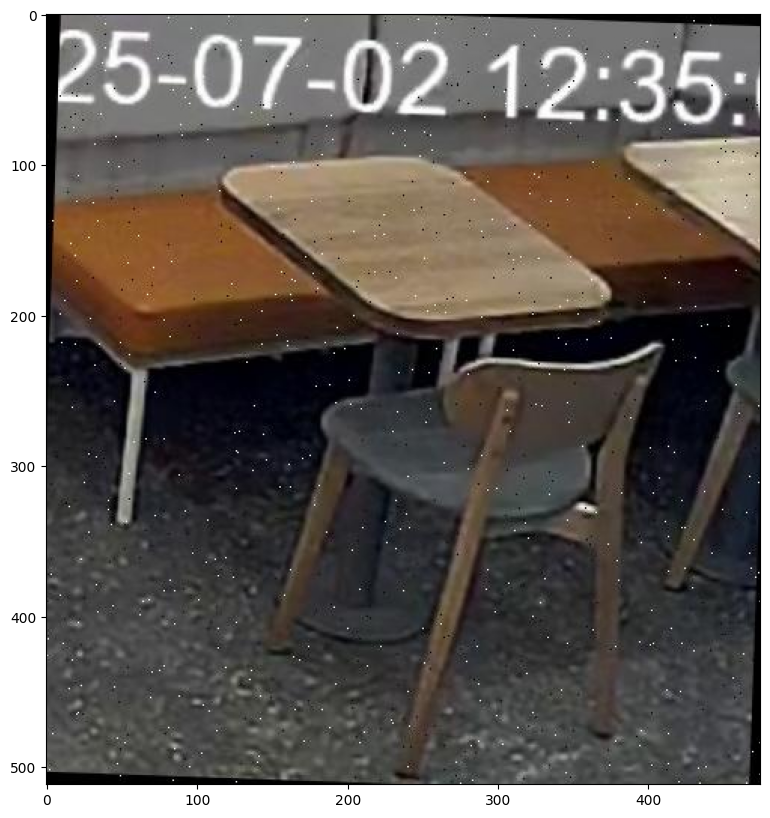

In [20]:
# Получение изображения и метки класса из набора
img_t, target = data[25]

print(f'Размер изображения: {img_t.shape}')
plt.figure(figsize=(10, 10))
plt.imshow(img_t.permute(1, 2, 0))

print(f"Метка класса: {target}")

## Работа генератора с выводом примерного времени ожидания прохода по пакетам

In [25]:
# Создаем DataLoader с размером пакета 64
dl = DataLoader(data, 64, num_workers=6,)

# Создание генератора по dl с выводом примерного времени ожидания
batch_iter = enumerateWithEstimate(dl, "Генератор прошел по", start_ndx=dl.num_workers)

for _ in batch_iter:
    pass

2025-11-08 01:03:44,754 WARNING  pid:48520     src.util.util:031:enumerateWithEstimate Генератор прошел по ----/46, starting


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ~~~~~~~~~~~~~~~^^^^^^
  File "/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
    ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 512, 431] at entry 0 and [3, 511, 432] at entry 1
